# kaggle - 2nd ML : house price prediction

- 데이터 전처리, 모델 학습, 예측
- 피처 엔지니어링 + 하이퍼 파라미터 튜닝으로 모델 최적화 : 110000이하의 private score를 만족하기

In [1]:
# 1. baseline 기반의 코드 작성
#라이브러리 임포트
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
print(xgb.__version__)
print(lgb.__version__)
print(msno.__version__)

2.0.0
4.1.0
0.5.0


In [3]:
#파일 경로 지정

data_dir = "/aiffel/aiffel/workspace/kaggle_house/data"
train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

print(train_data_path)
print(sub_data_path)

/aiffel/aiffel/workspace/kaggle_house/data/train.csv
/aiffel/aiffel/workspace/kaggle_house/data/test.csv


# 데이터 전처리

In [4]:
train = pd.read_csv(train_data_path)
test = pd.read_csv(sub_data_path)
print(f'train data dim : {train.shape}')
print(f'sub data dim : {test.shape}')

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [5]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  int64  
 6   sqft_lot       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  int64  
 13  sqft_basement  15035 non-null  int64  
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 non-null  float64
 18  long  

In [7]:
#object 타입 -> int 타입
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

In [8]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

def log_scaling(data, skew_columns):
    for c in skew_columns:
        data[c] = np.log1p(data[c].values)
    return data

log_scaling(train, skew_columns)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,1.386294,1.00,7.074117,8.639588,1.0,0,0,...,7,7.074117,0.0,1955,0,98178,47.5112,-122.257,7.201171,8.639588
1,1,201502,180000.0,1.098612,1.00,6.647688,9.210440,1.0,0,0,...,6,6.647688,0.0,1933,0,98028,47.7379,-122.233,7.908755,8.995041
2,2,201502,510000.0,1.386294,2.00,7.427144,8.997271,1.0,0,0,...,8,7.427144,0.0,1987,0,98074,47.6168,-122.045,7.496097,8.923191
3,3,201406,257500.0,1.386294,2.25,7.447751,8.827615,2.0,0,0,...,7,7.447751,0.0,1995,0,98003,47.3097,-122.327,7.713785,8.827615
4,4,201501,291850.0,1.386294,1.50,6.966967,9.181118,1.0,0,0,...,7,6.966967,0.0,1963,0,98198,47.4095,-122.315,7.409136,9.181118


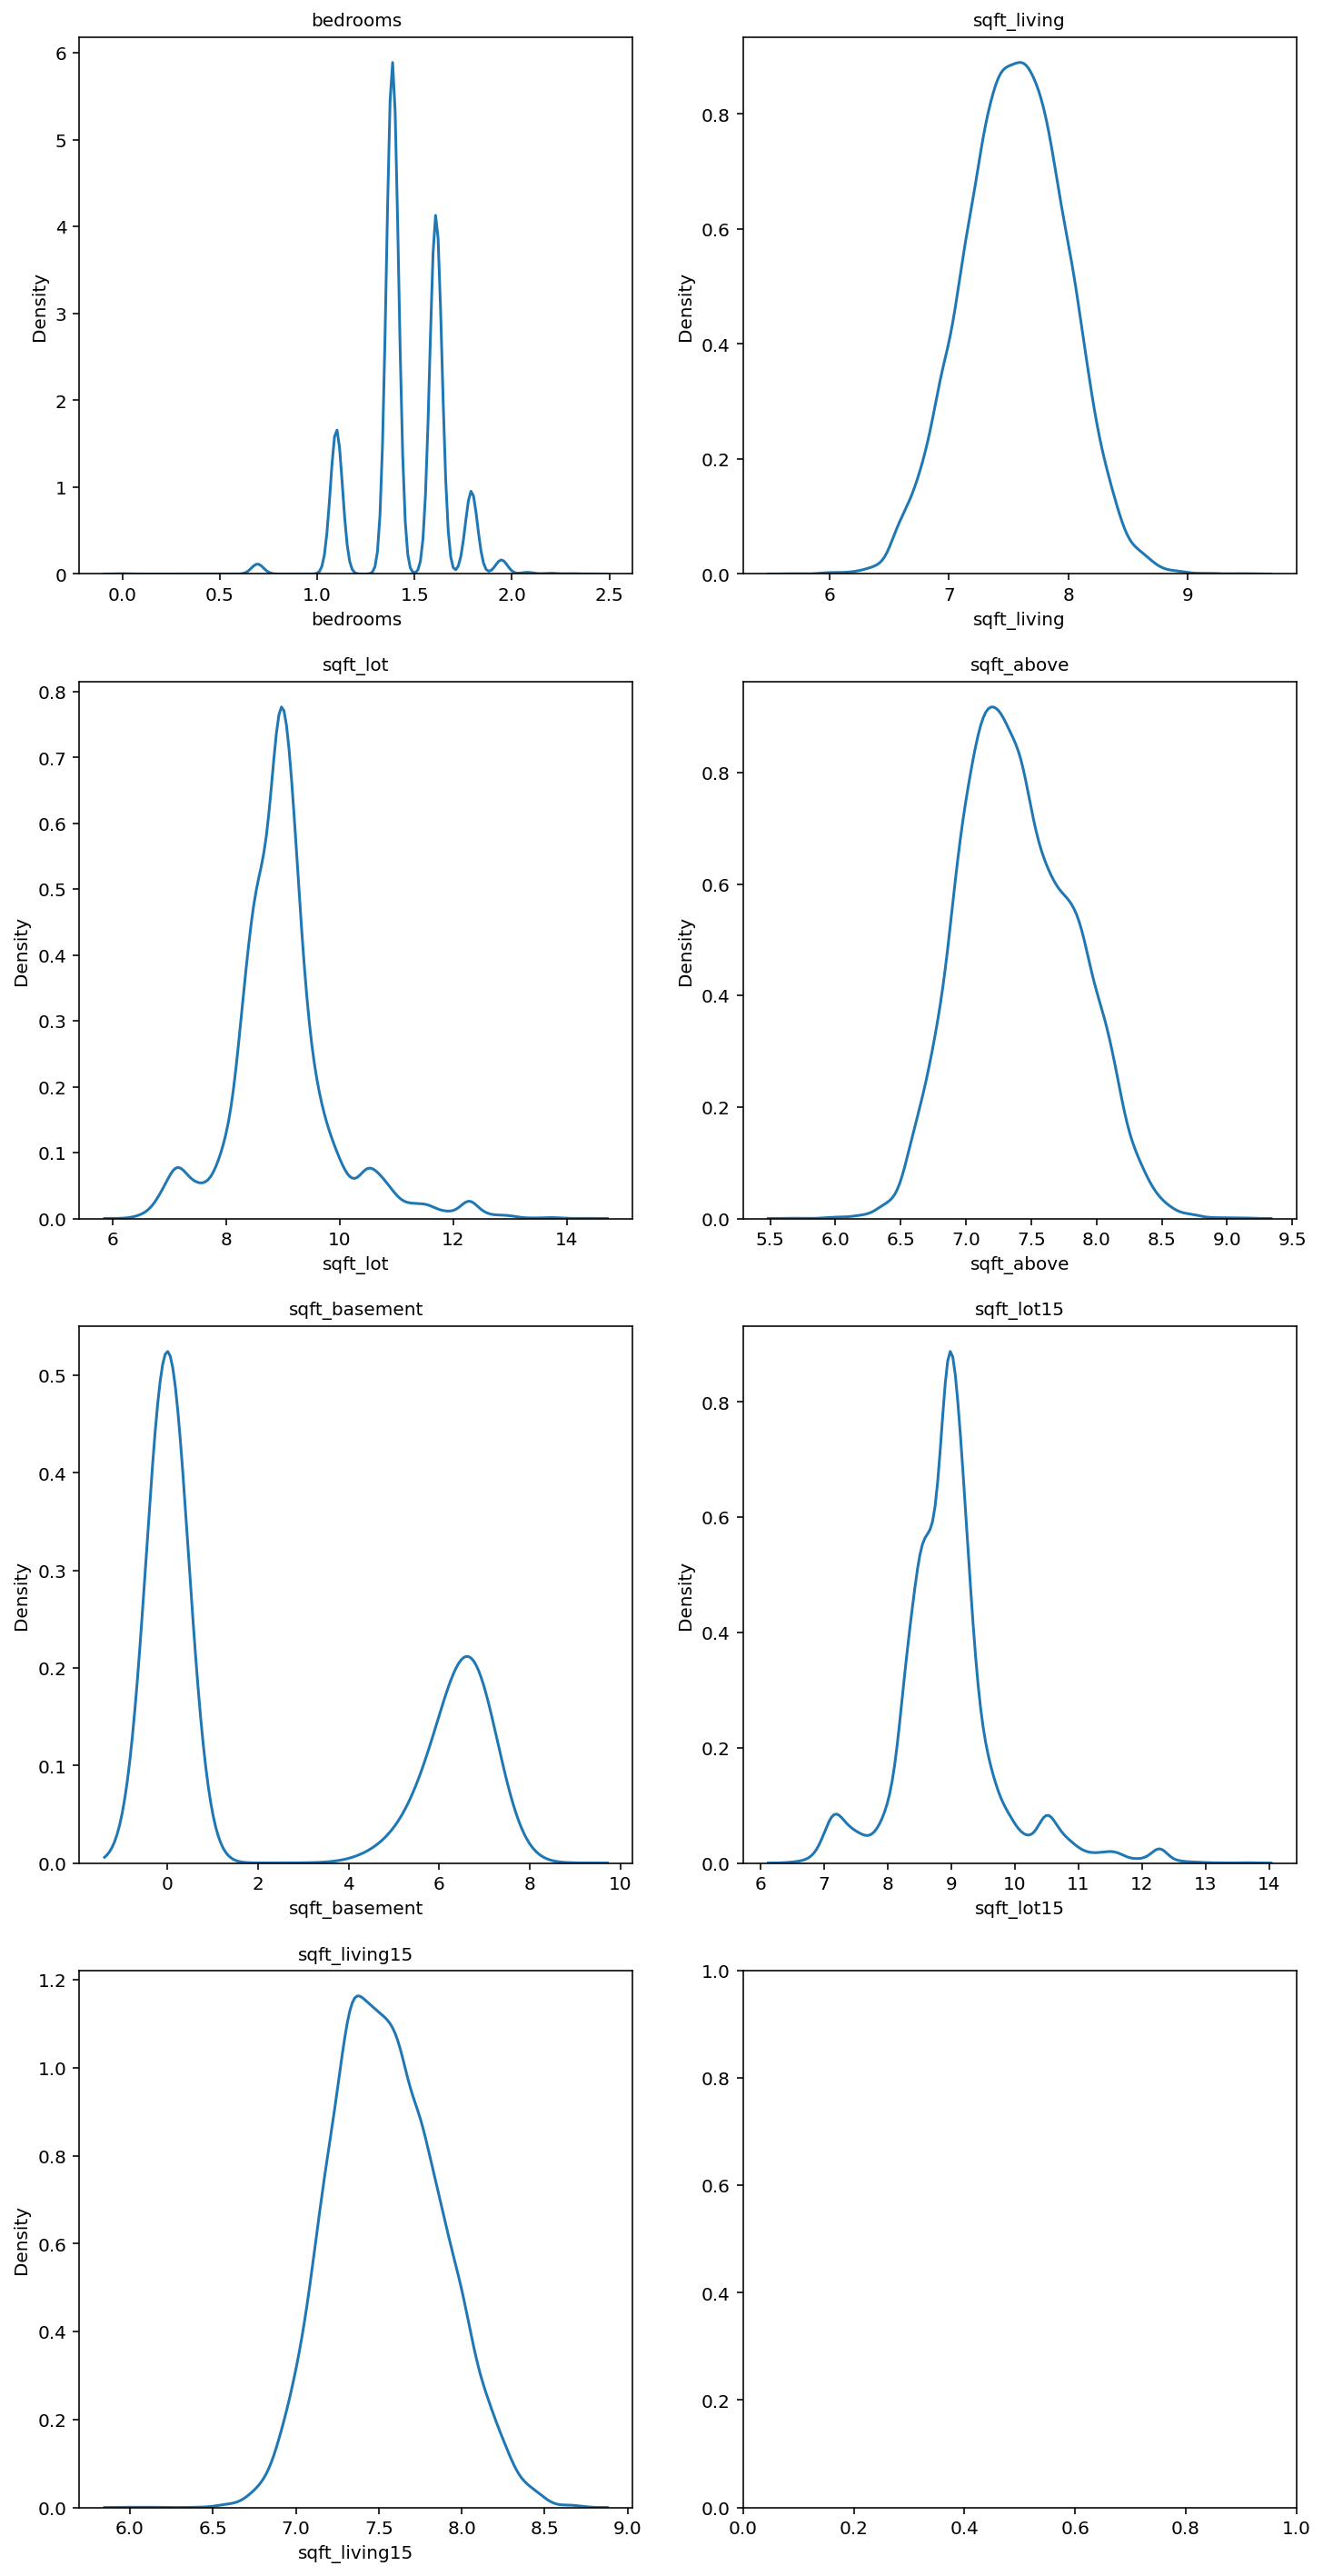

In [9]:
fig, ax = plt.subplots(4, 2, figsize=(12, 25))

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 0
columns = skew_columns
for row in range(4):
    for col in range(2):
        sns.kdeplot(data=train[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=10)
        count += 1
        if count == 7 :
            break

['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view' 'sqft_basement' 'waterfront'
 'yr_renovated' 'yr_built' 'sqft_lot' 'long' 'sqft_lot15' 'id' 'condition'
 'zipcode']


<AxesSubplot:>

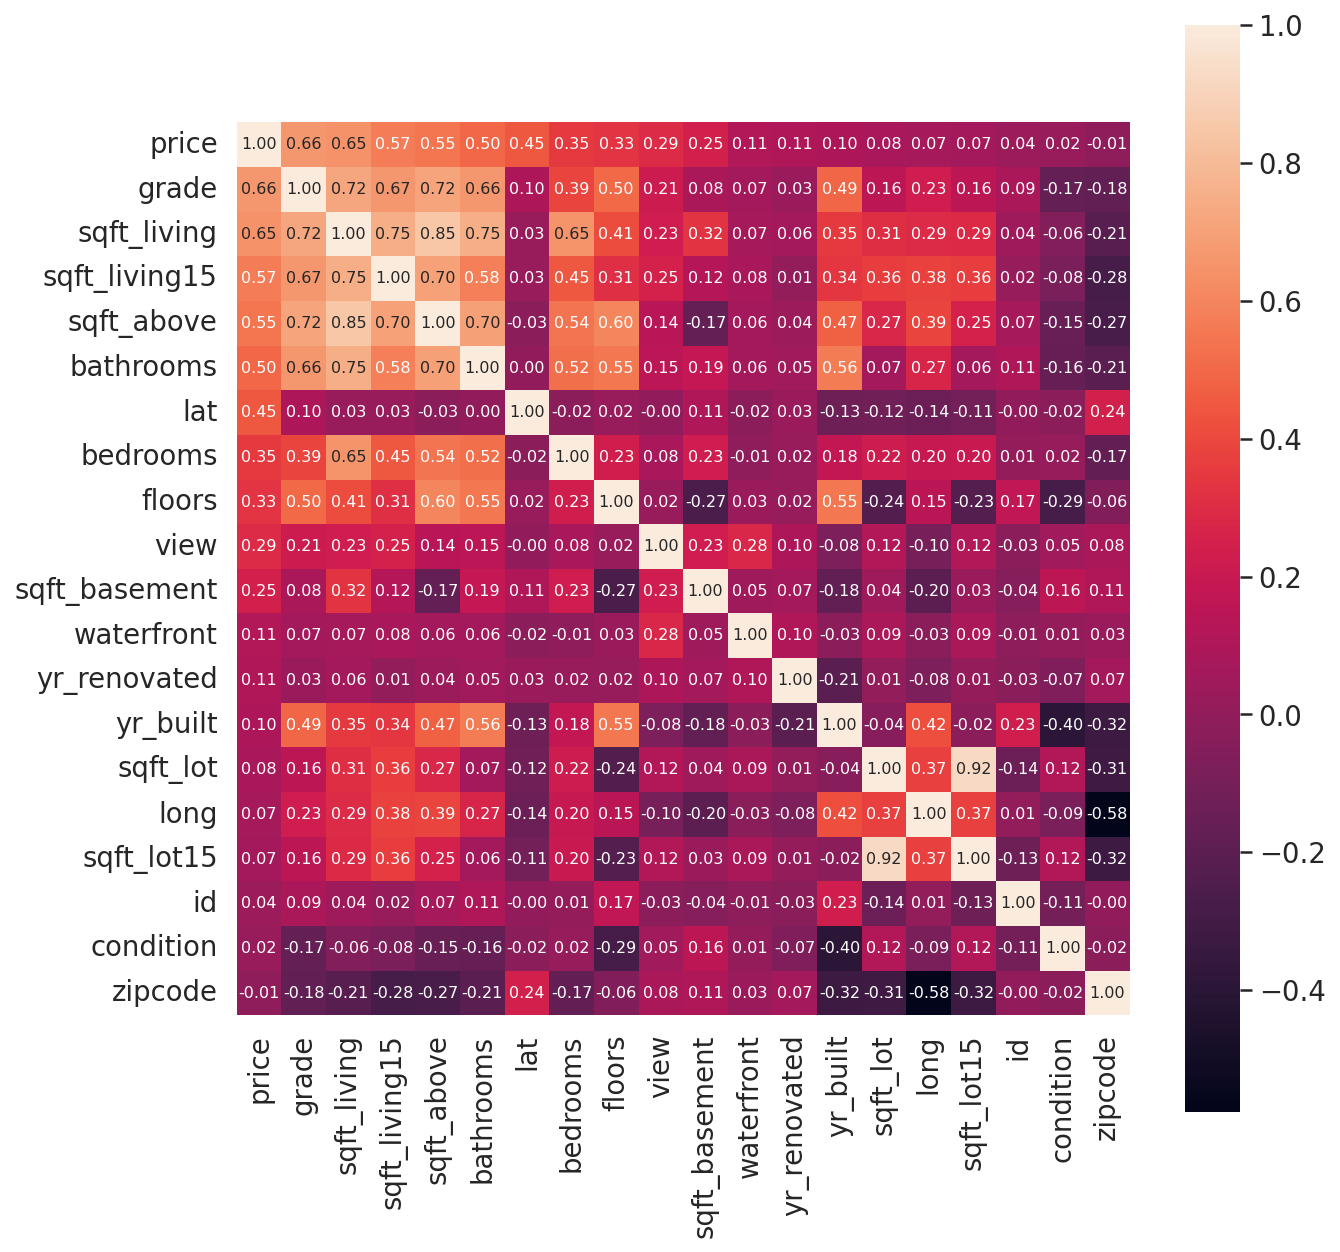

In [10]:
# 변수간 상관관계 파악
# continuous + sequential variables --> spearman
# abs는 반비례관계도 고려하기 위함

import scipy as sp

cor_abs = abs(train.corr(method='spearman')) 
cor_cols = cor_abs.nlargest(n=20, columns='price').index 

# spearman coefficient matrix
cor = np.array(sp.stats.spearmanr(train[cor_cols].values))[0] # 10 x 10
print(cor_cols.values)
plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, square=True , annot_kws={'size' : 8} ,xticklabels=cor_cols.values, yticklabels=cor_cols.values)

In [11]:
# 필요없는 feature 삭제
columns = ['price', 'grade', 'sqft_living', 'sqft_living15', 'sqft_above', 'bathrooms','lat', 'bedrooms', 'floors', 'view', 'sqft_basement']

train = train[columns]
train.head()

,price,grade,sqft_living,sqft_living15,sqft_above,bathrooms,lat,bedrooms,floors,view,sqft_basement
0,221900.0,7,7.074117,7.201171,7.074117,1.00,47.5112,1.386294,1.0,0,0.0
1,180000.0,6,6.647688,7.908755,6.647688,1.00,47.7379,1.098612,1.0,0,0.0
2,510000.0,8,7.427144,7.496097,7.427144,2.00,47.6168,1.386294,1.0,0,0.0
3,257500.0,7,7.447751,7.713785,7.447751,2.25,47.3097,1.386294,2.0,0,0.0
4,291850.0,7,6.966967,7.409136,6.966967,1.50,47.4095,1.386294,1.0,0,0.0


In [12]:
columns = ['grade', 'sqft_living', 'sqft_living15', 'sqft_above', 'bathrooms','lat', 'bedrooms', 'floors', 'view', 'sqft_basement']
test = test[columns]

In [13]:
# 학습데이터에서 라벨 제거 + 라벨 만들기
label = train['price']
del train['price']

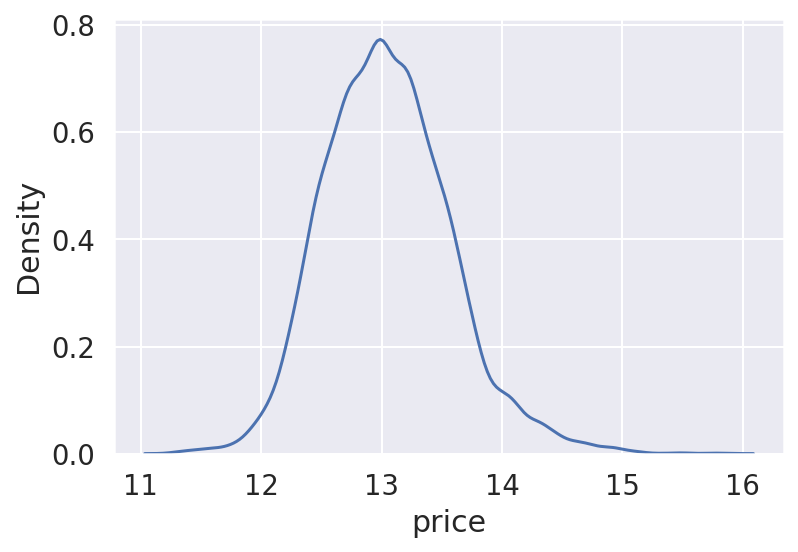

In [14]:
# price 로그 스케일링
log_label = np.log1p(label)
sns.kdeplot(log_label)
plt.show()

In [15]:
print(train.shape, test.shape)

(15035, 10) (6468, 10)


In [16]:
print(log_label.shape)

(15035,)


train, log_label / test

## 모델 학습하기 

In [ ]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

In [43]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [ ]:
y_pred = AveragingBlending(models, train, log_label, test)
print(len(y_pred))
y_pred

## 모델 튜닝

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [18]:
random_state=2020       
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor   

xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [xgboost, lightgbm, rdforest]

In [19]:
def get_scores(models, train, y):
    df = {}
    for model in models:
        # 모델 이름 획득
        model_name = model.__class__.__name__
        # train, test 데이터셋 분리
        # random_state를 사용하여 고정하고 train과 test 셋의 비율은 8:2로 합니다.
        X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2, shuffle=True, random_state=34) 

        # 모델 학습
        model.fit(X_train, y_train)
        # 예측
        y_pred = model.predict(X_test)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

        # 예측 결과의 rmse값 저장
        df[model_name] = rmse(y_pred, y_test)
    
        # data frame에 저장
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    return score_df

## 그리드 서치

In [29]:
from sklearn.model_selection import GridSearchCV

#rdforest
param_grid3 = {
    'n_estimators': [50,75,100],
    'max_depth': [2,6,8,10],
    'min_samples_split': [2, 3, 4],
}

#lgbm
param_grid2 = {
    'n_estimators': [50,75,100],
    'max_depth': [2,6,8,10],
    'learning_rate':[0.05,0.075,0.1]
}

#xgboost
param_grid1 = {
    'n_estimators': [50,75,100],
    'max_depth': [2,6,8,10],
    'eta':[0.05,0.075,0.1]
}

In [ ]:
'''
param_grid = {
    'n_estimators': [50,100],
    'max_depth': [1,10],
    'min_samples_split': [2, 3]
}
'''

In [21]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)

    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score

    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [27]:
model = models[0]
my_GridSearch(model, train, log_label,param_grid1,verbose=2,n_jobs=5)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


,eta,max_depth,n_estimators,score,RMSLE
17,0.075,6,100,-0.043422,0.208379
16,0.075,6,75,-0.043665,0.208961
5,0.050,6,100,-0.043678,0.208992
29,0.100,6,100,-0.043700,0.209046
28,0.100,6,75,-0.043764,0.209197
19,0.075,8,75,-0.043918,0.209566
8,0.050,8,100,-0.043928,0.209589
27,0.100,6,50,-0.043995,0.209751
20,0.075,8,100,-0.043998,0.209758
30,0.100,8,50,-0.044270,0.210406


In [30]:
model = models[1]
my_GridSearch(model, train, log_label,param_grid2,verbose=2,n_jobs=5)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001237 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1271
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 10
[LightGBM] [Info] Start training from score 13.050187
[CV] END ...learning_rate=0.05, max_depth=2, n_estimators=50; total time=   0.5s
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1300
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 10
[LightGBM] [Info] Start training from score 13.052839
[CV] END ...learning_rate=0.05, max_depth=2

,learning_rate,max_depth,n_estimators,score,RMSLE
31,0.100,8,75,-0.043199,0.207844
23,0.075,10,100,-0.043217,0.207888
32,0.100,8,100,-0.043223,0.207901
35,0.100,10,100,-0.043249,0.207963
34,0.100,10,75,-0.043276,0.208028
20,0.075,8,100,-0.043327,0.208151
22,0.075,10,75,-0.043411,0.208354
17,0.075,6,100,-0.043439,0.208419
19,0.075,8,75,-0.043483,0.208527
11,0.050,10,100,-0.043589,0.208780


In [33]:
model = models[2]
my_GridSearch(model, train, log_label,param_grid3, verbose=2,n_jobs=5)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


,max_depth,min_samples_split,n_estimators,score,RMSLE
35,10,4,100,-0.046928,0.216630
32,10,3,100,-0.046934,0.216642
29,10,2,100,-0.046954,0.216689
31,10,3,75,-0.047008,0.216813
34,10,4,75,-0.047015,0.216830
28,10,2,75,-0.047044,0.216895
30,10,3,50,-0.047106,0.217039
33,10,4,50,-0.047133,0.217101
27,10,2,50,-0.047157,0.217157
26,8,4,100,-0.049370,0.222195


# 최적의 파라미터 적용한 앙상블 모델 gboost, xgboost, lightgbm, rdforest

In [ ]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)


y_pred = AveragingBlending(models, train, log_label, test)
print(len(y_pred))
y_pred

In [48]:
#models = [gboost, xgboost, lightgbm, rdforest]

xgboost_b = XGBRegressor(max_depth=6,n_estimators=100, eta=0.075 ,random_state=random_state)
lightgbm_b = LGBMRegressor(max_depth=8,n_estimators=75,learning_rate=0.1 ,random_state=random_state)
rdforest_b = RandomForestRegressor(max_depth=10,n_estimators=100,min_samples_split=4,random_state=random_state)

In [49]:
models = [{'model':xgboost_b, 'name':'XGBoost'}, {'model':lightgbm_b, 'name':'LightGBM'}, {'model':rdforest_b, 'name':'RandomForest'}]
models_list = [xgboost_b, lightgbm_b, rdforest_b]

In [50]:
prediction = AveragingBlending(models, train, log_label, test)
print(prediction)
prediction = np.expm1(prediction)
print(prediction)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001087 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1309
[LightGBM] [Info] Number of data points in the train set: 15035, number of used features: 10
[LightGBM] [Info] Start training from score 13.048122
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may

In [51]:
submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission['price'] = prediction
submission_csv_path = 'submission_{}.csv'.format( 'p2')
submission.to_csv(submission_csv_path, index = False)

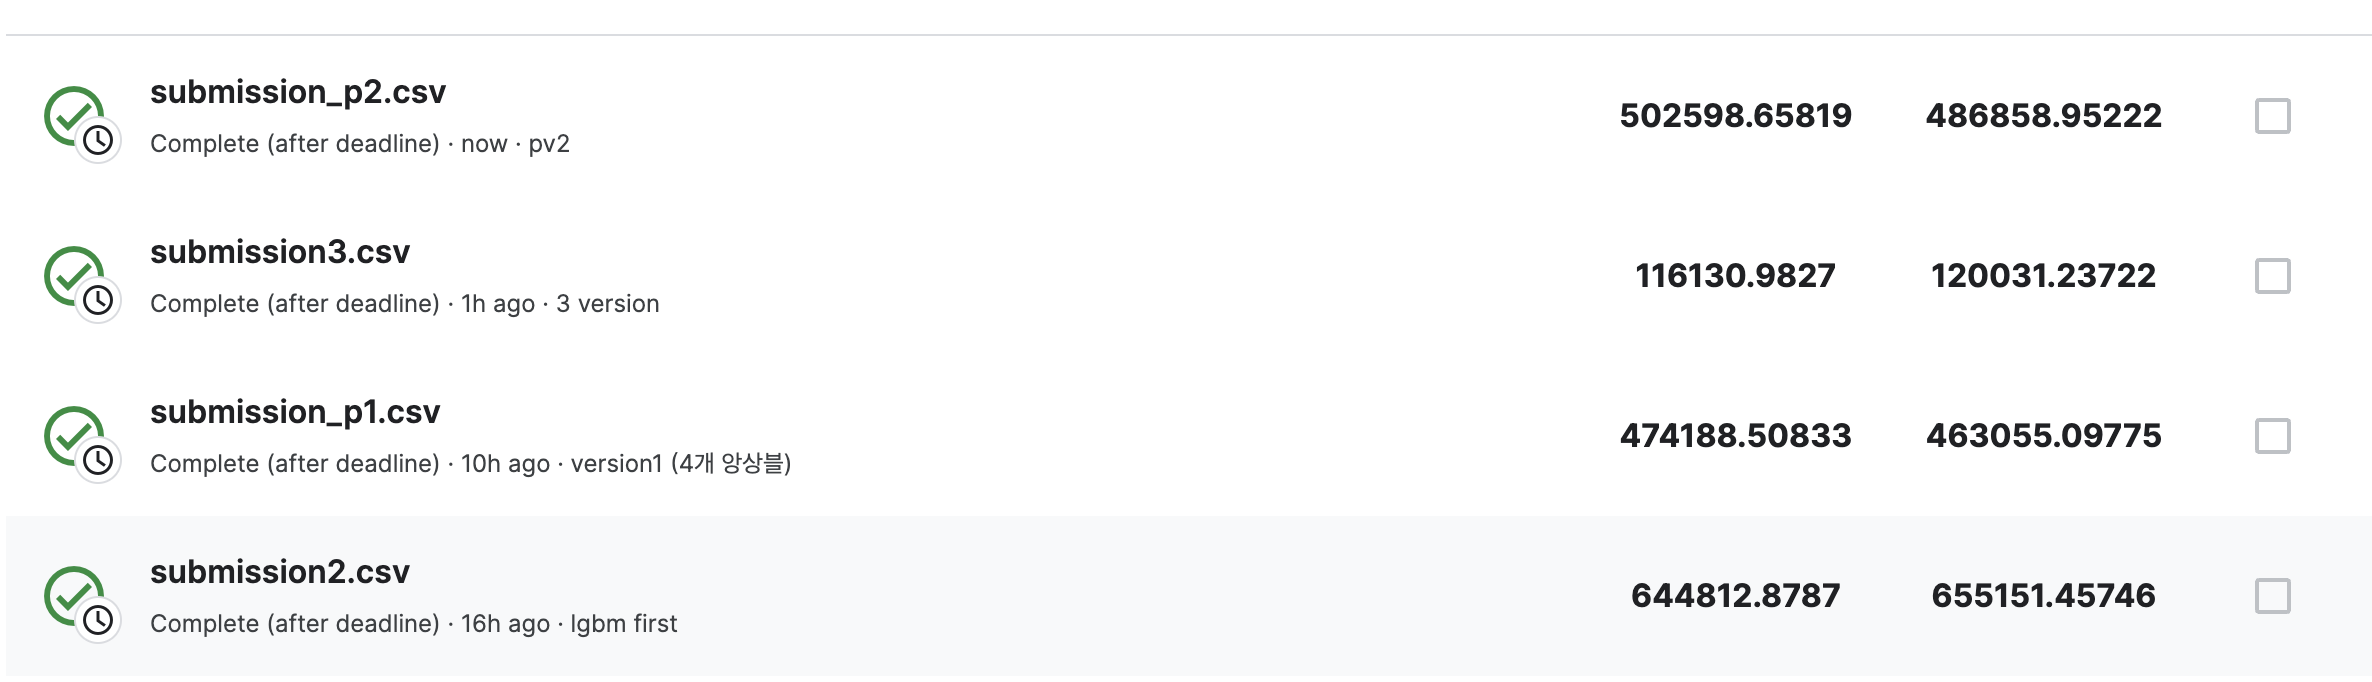